# Optical Pumping

Author: Dounan Du

Abstract: This is a numerical simulation of an idealized optical pumping process. 

In [145]:
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Image
import qutip
from qutip import (Qobj, about, basis, coherent, coherent_dm, create, destroy,
                   expect, fock, fock_dm, mesolve, qeye, sigmax, sigmay,
                   sigmaz, tensor, thermal_dm)
import math
from scipy import constants

%matplotlib inline

## Introduction

In quantum optical experiments, especially in thoses involve cold atoms, the quality of the optical pumping preparation of the atomic states is key to a clear demonstration of the core physics. This numerical simulation provides some insight on how the pumping quality is dependent on various pumping parameters, such as pumping Rabi frequency, pumping duration.

## Create Rb87 atomic structure 

The atomic structure is encoded in two fundamental class: HyperfineLevel and HyperfineTransition class.

In [146]:
class HyperfineLevel:

    """
    Atomic hyperfine sublevels are represented by this class.

    Attributes:
        F (int): The hyperfine level quantum number.
        mF (int): The Zeeman sublevel quantum number.
        FineStruc (int): the number represent the Fine level as follows: 0 - 5S1/2; 1 - 5P1/2; 2 - 5P3/2.
        levelIndex(int): the index of python ket vector elements represent this hyperfine sub level.
        n(int): the total dimension of the system Hilbert space.
        rho: density matrix of pure state of this level
        basis: ket vector base of this level

    """
    def __init__(self, F, mF, FineStruc, levelIndex, n):
        self.F = F
        self.mF = mF
        self.FineStruc = FineStruc
        self.levelIndex = levelIndex
        self.rho = qutip.fock_dm(n,levelIndex)
        self.basis = qutip.basis(n,levelIndex)

class HyperfineTransition:
    """
    Transitions between hyperfine Zeeman levels are represented by this class.

    Attributes:
        in_: represent initial hyperfine level(the lower energy), same numbering system as HyperfineLevel class.
        f_: represent final level.(the higher energy)
        reducedDipoleM (float): the reduce dipole moment of the form <J||er||J'>. Value from Steck data.
        dipoleM (float): dipole moment in units of related reduced dipole moment, value from Steck data.
        Pol (int): Polarization of the transition, with -1 - sigma-; 0 - pi; +1 - sigma+
        dipole: actual dipole moment of the form <F',m'|d_1|F,m> of sigma+ transition, where primed level is the excited level. since in Steck 
                it is given in <F,m|d_-1|F',m'> for sigma+. In Unit of hbar, since when define dipoleM is in unit of hbar
        Gamma(float): the atomic emission rate between two fine levels, the Gamma given from Steck's Rb data sheet. Unit: s^-1 or Hz
        hfGamma: the calculated emission rate of this specific hyperfine sublevel pair. Unit: s^-1
    
    """
    def __init__(self,in_FineStruc, in_F,in_mF,f_FineStruc,f_F,f_mF,reducedDipoleM,dipoleM,Pol,Gamma):
        self.in_FineStruc = in_FineStruc
        self.in_F = in_F
        self.in_mF = in_mF
        self.f_FineStruc = f_FineStruc
        self.f_F = f_F
        self.f_mF = f_mF
        self.reducedDipoleM = reducedDipoleM
        self.dipoleM = dipoleM
        self.Pol = Pol
        self.dipole = (-1)**(self.Pol) * np.conjugate(self.dipoleM * self.reducedDipoleM)
        self.Gamma = Gamma
        self.hfGamma = self.hyperfine_Gamma(Gamma, in_FineStruc, f_FineStruc, reducedDipoleM, self.dipole)

    def hyperfine_Gamma(self, Gamma, in_FineStruc, f_FineStruc, reducedDipoleM, dipole):
        fineStrucDictionary = {'0': 0.5, '1': 0.5, '2':1.5}
        Jg = fineStrucDictionary[str(in_FineStruc)]
        Je = fineStrucDictionary[str(f_FineStruc)]
        reduced_gamma = Gamma * (2*Je + 1) / ((2*Jg +1) * (abs(reducedDipoleM*constants.hbar))**2)#here assume reduced dipole is in unit of hbar, so revert it
        return reduced_gamma * (abs(dipole)*constants.hbar)**2





Now create a database to store the Steck Rb87 data as HyperfineTransition objects.

In [147]:
# this cell is a data base. Each enrty represent a hyperfine to hyperfine transition. Add relevent entry to the specific system.

rD02 = 3.584e-29/constants.hbar #87Rb reduced dipole matrix element <J=1/2||er||J'=3/2>, normalized by hbar
gamma_D2 = 38.11e6 #direct data from Steck Rb data sheet

database = []

# 87Rb D2 5S1/2 -> 5P3/2, sigma+ transition, F = 1 -> F' =2
entry1 = [[-1,math.sqrt(1/24)],[0,math.sqrt(1/8)],[1,math.sqrt(1/4)]]
for i in entry1:
    database.append(HyperfineTransition(0,1,i[0],2,2,i[0]+1,rD02,i[1],1,gamma_D2))

# 87Rb D2 5S1/2 -> 5P3/2, pi transition, F = 1 -> F' =2
entry2 = [[-1,-math.sqrt(1/8)],[0,-math.sqrt(1/6)],[1,-math.sqrt(1/8)]]
for i in entry2:
    database.append(HyperfineTransition(0,1,i[0],2,2,i[0],rD02,i[1],0,gamma_D2))

# 87Rb D2 5S1/2 -> 5P3/2, sigma- transition, F = 1 -> F' =2
entry3 = [[-1,math.sqrt(1/4)],[0,math.sqrt(1/8)],[1,math.sqrt(1/24)]]
for i in entry3:
    database.append(HyperfineTransition(0,1,i[0],2,2,i[0]-1,rD02,i[1],-1,gamma_D2))

# 87Rb D2 5S1/2 -> 5P3/2, sigma+ transition, F = 2 -> F' =2
entry4 = [[-2,math.sqrt(1/12)],[-1,math.sqrt(1/8)],[0,math.sqrt(1/8)],[1,math.sqrt(1/12)]]
for i in entry4:
    database.append(HyperfineTransition(0,2,i[0],2,2,i[0]+1,rD02,i[1],1,gamma_D2))

# 87Rb D2 5S1/2 -> 5P3/2, pi transition, F = 2 -> F' =2
entry5 = [[-2,-math.sqrt(1/6)],[-1,-math.sqrt(1/24)],[0,0],[1,math.sqrt(1/24)],[2,math.sqrt(1/6)]]
for i in entry5:
    database.append(HyperfineTransition(0,2,i[0],2,2,i[0],rD02,i[1],0,gamma_D2))

# 87Rb D2 5S1/2 -> 5P3/2, sigma- transition, F = 2 -> F' =2
entry6 = [[-1,-math.sqrt(1/12)],[0,-math.sqrt(1/8)],[1,-math.sqrt(1/8)],[2,-math.sqrt(1/12)]]
for i in entry6:
    database.append(HyperfineTransition(0,2,i[0],2,2,i[0]-1,rD02,i[1],-1,gamma_D2))
    

Specify the fine level and hyperfine levels that are included in the system model, here the matrix represention is under the convention that in python numpy array, smaller index corresponds to lower energy levels. For example, for kets $\ket{e}$ and $\ket{g}$, the corresponding vector is np.array([[0],[1]]) and np.array([[1],[0]]).

The involved hyperlevels are specified by a np array. For example for the $5S_{1/2}\ F=1$ hyperfine level the identify column vector is np.array([[0,1]])

here input the involved levels. For example: $5S_{1/2}\ F=1,2$ and $5P_{3/2}\ F = 2$ (__change according to specific system__)

In [148]:
#specify related hyperfine levels, order them as increacing energy
levelInvolved = np.array([[0,1],[0,2],[2,2]])

Define a function to automatically generate all sub-level objects from the provided involved levels, and generate a index list that encodes the structure information.

In [149]:
def Gen_levelStruct(levelInvolved):

    """
    automatically generate all sub-level objects from the provided involved levels
    
    """

    n = (np.sum(levelInvolved,axis=0)[1])*2 + levelInvolved.shape[0] #find total dimension of the Hilbert space
    l = [None] * n #initialize the list that hold all sub hperfine level objects.

    j=0 #this for loop structure generate a list of all the involved level objects, and they are ordered as increacing of energy
    for i in range(levelInvolved.shape[0]): 
        subLvs = range(2*levelInvolved[i,1]+1)-levelInvolved[i,1]
        for hyLevels in subLvs:
            l[j] = HyperfineLevel(levelInvolved[i,1],hyLevels,levelInvolved[i,0],j,n)
            j+=1

    # creating a list of the atomic level index that encodes the level structure 
    lIndex = [None] * n
    for i in range(n):
        lIndex[i] = i

    segment_length = []
    for i in levelInvolved:
        segment_length.append(i[1] * 2 + 1)

    start = 0
    lStructure_list = []

    for length in segment_length:
        end = start + length
        lStructure_list.append(lIndex[start:end])
        start = end

    return l,lStructure_list

#l,lStructure_list = Gen_levelStruct(levelInvolved)

## Generate initial density operator

Assume initially the atom pupolation is equally distributed over $5S_{1/2}\ F=2$ hyperfine Zeeman levels. The initial state can be modified according to the model. (__change according to specific system__)

In [150]:
# generate the initial atomic density operator in rotating frame.
inRhoL = 1 # here input the initial rho hyperfine level(inRhoL), using indexing refer to levelInvolved

def rhoRE_initialize(inRhoL, l, lStructure_list):
    rhoRF_i = 0
    weight = 1/len(lStructure_list[inRhoL])
    for i in lStructure_list[inRhoL]:
        rhoRF_i += l[i].rho * weight
    return rhoRF_i

#rhoRF_i = rhoRE_initialize(inRhoL,l,lStructure_list)

## Generate rotating frame Hamiltonian

### Define pumping beams

The PumpBeam class generate pump beam object that encode various attributes of the pump beam. Here assume the Gaussian beam waist is at the atomic ensemble location so that a plane wave will be a good approximation to model the beam. The size of the beam can be approximated by the beam waist diameter. In vaccum, the field of the beam will be calculated from 
$$
\begin{equation}
\begin{aligned}
\mathbf{S} &= \frac{1}{2}\sqrt{\frac{\epsilon_0}{\mu_0}}|E_0|^2\\
&=\frac{1}{2}c\epsilon_0|E_0|^2\\
\end{aligned}
\end{equation}
$$
where $E_0$ is the physical strength of the field.

In [151]:
class PumpBeam:
    def __init__(self,lowL, highL, detune, beamDia, power, pol) -> None:
        
        """
        This class define the pump beam objects.

        Attributes:
            lowL(list): this is the lower hyperfine level that the laser field connects. It is specified similar as levelInvolved, [fine_level_index, hyperfine].
            highL(list): the higher hyperfine level that the laser field connectes, defined in the same way as the lowL.
            detune(float): detune from the corresponding atomic transition frequency. Convention: omega_laser - omega_atomic. Unit: Hz.
            beamDia(float): beam diameter at the atom ensemble. Unit: mm 
            power(float): beam power at the atom ensemble. Unit: mW
            pol(int): beam field polarization at the atom ensemble. Represented by spherical basis components E_q, where q = 1,0,-1 
        """
        
        self.lowL = lowL
        self.highL = highL
        self.detune = detune
        self.beamDia = beamDia
        self.power = power
        self.pol = pol
        self.field = self.fieldStrengh(power,beamDia)
    
    def fieldStrengh(self,power,beamDia):
        beamArea = np.pi * ((beamDia * 1e-3 / 2)**2)
        beamIntensity = power * 1e-3 / beamArea
        field = math.sqrt(2 * beamIntensity /(constants.c * constants.epsilon_0))
        return field


Specify pump beam in the experiment setup. (__change according to specific system__)

In [152]:
beamInvolved = [PumpBeam([0,1],[2,2],0,1,3,-1), PumpBeam([0,2],[2,2],80e6,1,3,-1)] # Note: the beam connecting lower ground states should have smaller list index.

### Free atom Hamiltonian in rotating frame

For optical pumping, the system is often a $\lambda$ type configuration. In this configuration, it is convenient to use the upper excited level as the energy reference for the rotating frame transformation.

$$
\begin{equation}
\begin{aligned}
H_0 &=
\begin{pmatrix}
-\hbar \omega_1^{(i)} \\
 & ...\\
 &  & -\hbar \omega_2^{(i)}\\
& & &...\\
& & & & 0\\
\end{pmatrix}
\end{aligned}
\end{equation}
$$
where superscripts on $\omega$ represent different hyperfine Zeeman sublevels.

To transform to the rotating frame, $\ket{\tilde{\psi}} = \hat{U}\ket{\psi}$, the unitary operator here is
$$
\begin{equation}
\begin{aligned}
\hat{U} &= \sum_i exp({-i\omega_1\ket{g_1^{(i)}}\bra{g_1^{(i)}}}) + \sum_i exp({-i\omega_2\ket{g_2^{(i)}}\bra{g_2^{(i)}}})
\end{aligned}
\end{equation}
$$

so that 
$$
\begin{equation}
\begin{aligned}
\hat{\tilde{H}}_0 &= \sum_i \hbar \Delta_{g_1}^{(i)}\ket{g_1^{(i)}}\bra{g_1^{(i)}} + \sum_i \hbar \Delta_{g_2}^{(i)}\ket{g_2^{(i)}}\bra{g_2^{(i)}}
\end{aligned}
\end{equation}
$$

generate free atom Hamiltonian in rotating frame, here assume a $\lambda$ type pumping. (__change according to specific system__)

In [153]:
def H0_Lambda(l,lStructure_list,beamInvolved): #defien the free Hamiltonian, notice it is in unit of hbar.
    H0 = 0
    for i in range(len(lStructure_list)-1):
        for j in lStructure_list[i]:
            H0 += l[j].rho * beamInvolved[i].detune * 2 * np.pi
    return H0

#H0_RF = H0_Lambda(l,lStructure_list,beamInvolved)

### Atom-field interaction Hamiltonian in rotating frame

In the rotating frame, under the RWA, the interaction Hamiltonian is 
$$
\begin{equation}
\begin{aligned}
\hat{\tilde{H}}_{AF} &= - \mathbf{d}^{(+)} \cdot \mathbf{E}^{(-)} - \mathbf{d}^{(-)}\cdot\mathbf{E}^{(+)}\\
&= \sum_{i,j}-(\bra{g_j^i}\hat{\varepsilon}\cdot\mathbf{d}\ket{e}\sigma_{j,i} E_0^{(-)}+\bra{e}\hat{\varepsilon}\cdot\mathbf{d}\ket{g_j^i}\sigma_{j,i}^{\dagger} E_0^{(+)})
\end{aligned}
\end{equation}
$$

where here we will assume the field is zero phase so $E_0^{(+)}=E_0^{(-)}=E_0/2$, where $E_0$ is the physical field strength in the PumpBeam.field attribute. Here index $j$ represent different ground hyperfine level, while $i$ represents different hyperfine Zeeman sublevel within $j$ hyperfine level.

simplify further, use spherical basis to evaluate the vector product, where
$$
\begin{equation}
\begin{aligned}
\hat{\varepsilon}\cdot\mathbf{d} &=\sum_{q} (-1)^{q}\varepsilon_{q}\hat{d}_{-q}
\end{aligned}
\end{equation}
$$

so we can write
$$
\begin{equation}
\begin{aligned}
\hat{\tilde{H}}_{AF}
&= \sum_{i,j}-(\bra{g_j^i}(\sum_{q} (-1)^{q}\varepsilon_{q}\hat{d}_{-q})\ket{e}\frac{E_0}{2}\sigma_{j,i} +\bra{e}(\sum_{q} (-1)^{q}\varepsilon_{q}\hat{d}_{-q})\ket{g_j^i}\frac{E_0}{2}\sigma_{j,i}^{\dagger})
\end{aligned}
\end{equation}
$$


since we are using spherical basis, the spherical components of the dipole operator is no longer Hermitian, the following relatiion will be used
$$
\begin{equation}
\begin{aligned}
\bra{F,m_F}d_q\ket{F',m'_F} &= (-1)^{-q}\bra{F',m'_F}d_{-q}\ket{F,m_F}^*
\end{aligned}
\end{equation}
$$

In Steck's Rb spec sheet, in the table section, the dipole moment from F,m -> F',m', $\sigma^+$ tansition is actually means the object
$$
\begin{equation}
\begin{aligned}
\bra{F,m_F}d_{-1}\ket{F',m'_F}
\end{aligned}
\end{equation}
$$
where primed level corresponds to $\ket{e}$ the excited level

Here since we are using spherical basis, the field corresponds to $\sigma^+$ transition should be decomposed as
$$
\begin{equation}
\begin{aligned}
\vec{E}(t) &= \frac{E_0}{2}(\hat{e}_{+1}e^{i\omega t}-\hat{e}_{-1}e^{-i\omega t})\\
&= E_0[cos(\omega t)\hat{x} + cos(\omega t + \frac{\pi}{2})\hat{y}]\\
\end{aligned}
\end{equation}
$$
so we identify
$$
\begin{equation}
\begin{aligned}
\mathbf{E}^{(+)} &=  -\hat{e}_{-1}e^{-i\omega t}\\
\mathbf{E}^{(-)} &=  \hat{e}_{1}e^{i\omega t}\\
\end{aligned}
\end{equation}
$$

In [154]:
def Haf(l,lStructure_list,beamInvolved,database):
    Haf_RF = 0
    for i in beamInvolved:
        transitions = [] #find all transitions corresponds to this pump beam
        transitions = [transition for transition in database if transition.in_FineStruc == i.lowL[0] and \
                       transition.in_F == i.lowL[1] and \
                       transition.f_FineStruc == i.highL[0] and \
                       transition.f_F == i.highL[1] and \
                       transition.Pol == -1*i.pol]
        #find all [low_index, high_index] atomic level pairs corresponding to all transitions in the list

        for j in transitions:
            lowLevelKet = [level for level in l if level.FineStruc == j.in_FineStruc and \
                           level.F == j.in_F and \
                           level.mF == j.in_mF][0].basis
            highLevelKet = [level for level in l if level.FineStruc == j.f_FineStruc and \
                           level.F == j.f_F and \
                           level.mF == j.f_mF][0].basis
            atomSigma = lowLevelKet * highLevelKet.dag()
            atomSigma_dag = highLevelKet * lowLevelKet.dag()

            '''
            transition_dual = [dual for dual in database if dual.in_FineStruc == j.in_FineStruc and \
                               dual.in_F == j.in_F and \
                               dual.in_mF == j.in_mF and \
                               dual.f_FineStruc == j.f_FineStruc and \
                               dual.f_F == j.f_F and \
                               dual.f_mF == j.f_mF and \
                               dual.Pol == -1 * j.Pol]
            dual_dipoleM = 0
            if not transition_dual:
                dual_dipoleM = 0
            else:
                dual_dipoleM = (-1)**(-j.Pol) * np.conjugate(transition_dual[0].dipole)
            '''
            
            Haf_RF += (-1)**(j.Pol) * (i.field/2) * (j.dipole * atomSigma_dag \
                                                            +  j.dipole * atomSigma) * (-1) #original: dual_dipoleM * atomSigma
    return Haf_RF
    

In [155]:
#Haf_RF = Haf(l,lStructure_list,beamInvolved,database)

The total Hamiltonian in rotating frame is

In [156]:
#H_RF = H0_RF + Haf_RF

## Lindblad

### Hyperfine decay rates

In the optical pumping model, only consider the atomic decay channel. 

The spontaneous emission rate from $\ket{e}$ to $\ket{g}$ is
$$
\begin{equation}
\begin{aligned}
\Gamma &= \frac{\omega^{3}_0 |\bra{g}\mathbf{d}\ket{e}|^2}{3 \pi \epsilon_0 \hbar c^3}
\end{aligned}
\end{equation}
$$
For hyperfine Zeeman substates, emission rate is 
$$
\begin{equation}
\begin{aligned}
\Gamma &= \frac{\omega^{3}_0 |\bra{F',m'}\mathbf{d}\ket{F,m}|^2}{3 \pi \epsilon_0 \hbar c^3}
\end{aligned}
\end{equation}
$$
whrere the primed states represent state with higher energy.

In Steck's spec sheet, the decay rate of a fine level to another fine level is given as
$$
\begin{equation}
\begin{aligned}
\Gamma &= \frac{\omega^{3}_0 }{3 \pi \epsilon_0 \hbar c^3}\frac{2J_g + 1}{2J_e + 1}|\bra{J_g}\mathbf{d}\ket{J_e}|^2
\end{aligned}
\end{equation}
$$
we can thus use this emission rate to find specific emission rate between two hyperfine sublevels. This is programmed as an attribute in the HyperfineTransition class.

### Generate Lindblad operator list

In [157]:
def Lindblad(l,database):
    lindblad_list = []
    for level in l:
        transitions = [transition for transition in database if transition.f_FineStruc == level.FineStruc and \
                       transition.f_F == level.F and \
                       transition.f_mF == level.mF]
        for i in transitions:
            groundState = [state for state in l if state.FineStruc == i.in_FineStruc and \
                           state.F == i.in_F and \
                           state.mF == i.in_mF][0]
            lindblad = np.sqrt(i.hfGamma) * (groundState.basis * level.basis.dag())
            lindblad_list.append(lindblad)
    return lindblad_list

   


In [158]:
#lindblad_list  = Lindblad(l,database)

## Master equation, time evolution

In [159]:
def timeEvo(levelInvolved, database, inRhoL, beamInvolved,tlist):
    l,lStructure_list = Gen_levelStruct(levelInvolved)
    rhoRF_i = rhoRE_initialize(inRhoL,l,lStructure_list)
    H0_RF = H0_Lambda(l,lStructure_list,beamInvolved)
    Haf_RF = Haf(l,lStructure_list,beamInvolved,database)
    H_RF = (H0_RF + Haf_RF)
    lindblad_list  = Lindblad(l,database)

    res = qutip.mesolve(H = H_RF, rho0 = rhoRF_i, tlist = tlist, c_ops=lindblad_list) #progress_bar=qutip.ui.progressbar.BaseProgressBar)
    return res, Haf_RF, lindblad_list

plot the population

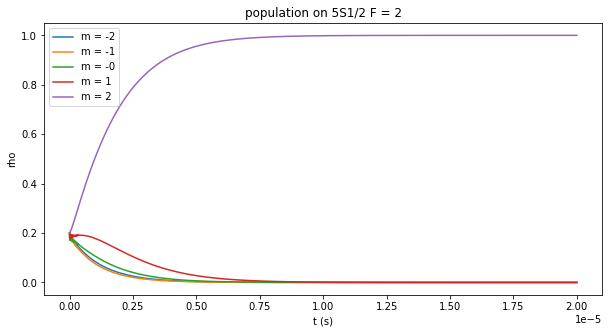

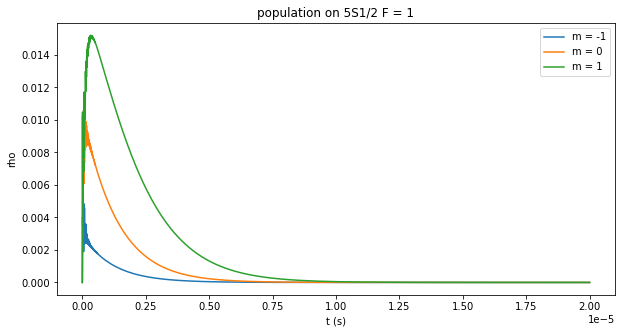

In [160]:
viewpoints = 100000
tlist = np.linspace(0, 20e-6, viewpoints)
result, h,ld = timeEvo(levelInvolved, database, inRhoL, beamInvolved,tlist)

x = result.states

rho1 = []
rho2 = []
rho3 = []
rho4 = []
rho5 = []
rho11 = []
rho12 = []
rho13 = []
for i in range(viewpoints):
    rho1.append(x[i][3,3].real)
    rho2.append(x[i][4,4].real)
    rho3.append(x[i][5,5].real)
    rho4.append(x[i][6,6].real)
    rho5.append(x[i][7,7].real)
    rho11.append(x[i][0,0].real)
    rho12.append(x[i][1,1].real)
    rho13.append(x[i][2,2].real)



plt.figure(figsize=(10, 5))
plt.plot(tlist,rho1, label='m = -2')
plt.plot(tlist,rho2, label='m = -1')
plt.plot(tlist,rho3, label='m = -0')
plt.plot(tlist,rho4, label='m = 1')
plt.plot(tlist,rho5, label='m = 2')

plt.xlabel('t (s)')
plt.ylabel('rho')
plt.legend()
plt.title('population on 5S1/2 F = 2')
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(tlist,rho11, label='m = -1')
plt.plot(tlist,rho12, label='m = 0')
plt.plot(tlist,rho13, label='m = 1')


plt.xlabel('t (s)')
plt.ylabel('rho')
plt.legend()
plt.title('population on 5S1/2 F = 1')
plt.show()